In [307]:
from pydantic import BaseModel
from typing import List, Optional
from langchain.schema import BaseMessage, HumanMessage, Document
from langgraph.graph import StateGraph, END, MessagesState
from typing import Annotated
from langgraph.graph import add_messages, StateGraph, END

class SupervisorState(MessagesState):
    """State for the multi-agent system"""
    messages = Annotated[List,add_messages]
    next_agent: str = ""
    Images_data: str = ""
    scientific_data: str =""
    products_data: str = ""
    final_answer: str = ""
    task_complete: bool = False
    current_task: str = ""

In [308]:
from typing import TypedDict, Annotated, List, Literal, Dict, Any
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
import random
from datetime import datetime

In [309]:
from langchain_core.prompts import ChatPromptTemplate
from google import genai


In [310]:
from dotenv import load_dotenv
load_dotenv()

True

In [311]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import ChatOpenAI
#llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash", temperature=0.5)
llm = ChatOpenAI(model_name="gpt-4o", temperature=0.5)

In [312]:
def create_supervisor_chain():
    supervisor_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a supervisor managing a team of agents:
        
        1. image_analyzer - analyzes an input image
        2. scientific_researcher - retrieves scientific data
        3. prodcuts_expert - provides haircare product info

        Decide which agent should work next based on progress.
        If everything is complete, respond with 'DONE'.

        Current state:
        - Has image data: {has_image}
        - Has scientific data: {has_scientific}
        - Has product info: {has_product_info}
        - Has final answer: {has_final_answer}

        Respond ONLY with one of:
        image_analyzer / scientific_researcher / prodcuts_expert / DONE
        """),
        ("human", "{task}")
    ])
    return supervisor_prompt | llm


In [313]:
def supervisor_agent(state: SupervisorState) -> Dict:
    """Supervisor decides next agent using gemini-2.5-flash LLM."""
    messages = state["messages"]
    task = messages[-1].content if messages else "No task"
    
    # Completion flags
    has_image = bool(state.get("Images_data"))
    has_scientific = bool(state.get("scientific_data"))
    has_product_info = bool(state.get("products_data"))
    has_final_answer = bool(state.get("final_answer"))

    # Get LLM decision
    chain = create_supervisor_chain()
    decision = chain.invoke({
        "task": task,
        "has_image": has_image,
        "has_scientific": has_scientific,
        "has_product_info": has_product_info,
        "has_final_answer": has_final_answer
    })

    decision_text = decision.content.strip().lower()
    print("🧠 Supervisor Decision:", decision_text)

    print(decision_text)

    # Routing logic
    if "done" in decision_text or has_final_answer:
        next_agent = "final_answer_agent"
        supervisor_msg = "✅ Supervisor: All tasks complete! Great work team."
        print(state)
    elif "image_analyzer" in decision_text or not has_image:
        next_agent = "image_analysis_agent"
        supervisor_msg = "📋 Supervisor: Let's start with the image analysis..."
        print(state)
    elif "scientific_researcher" in decision_text or (has_image and not has_scientific):
        next_agent = "scientific_data_agent"
        supervisor_msg = "📋 Supervisor: Image analyzed. Moving to scientific research..."
        print(state)
    elif "prodcuts_expert" in decision_text or (has_scientific and not has_product_info):
        next_agent = "products_data_agent"
        supervisor_msg = "📋 Supervisor: Scientific research complete. Assigning to product expert..."
        print(state)
    else:
        next_agent = "final_answer_agent"
        supervisor_msg = "✅ Supervisor: Proceeding to final report."
        print(state)

    return {
        "messages": [AIMessage(content=supervisor_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [314]:
from openai import OpenAI
import base64

In [315]:
import os

In [316]:
import base64
from openai import OpenAI
from langchain_core.messages import AIMessage

def image_analysis_agent(state):
    """Agent that analyzes a hair image using GPT-4o."""
    image_path = "test.png"  # Path to the input image
    client = OpenAI()

    # Read and encode image in base64
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

    # Build the multimodal message for GPT-4o
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an expert in hair care. Analyze the provided image and describe the hair type.\n\n"
                    "Possible hair types are:\n"
                    "- Heavily Damaged & Dry\n"
                    "- Colored & Bleached\n"
                    "- Heavily Damaged\n"
                    "- Damaged & Dry\n"
                    "- Dry, Damaged\n"
                    "- Dry & Colored\n"
                    "- Damaged & Bleached\n"
                    "- Strawy, Damaged\n"
                    "- Brittle & Dull\n"
                    "- Prone to Split Ends\n"
                    "- Normal to Dry\n"
                    "- Fine & Slightly Dry\n"
                    "- Normal & Fine\n"
                    "- Long hair with greasy roots\n"
                    "- Long hair, fine & normal\n"
                    "- Long hair with dry tips\n\n"
                    "Provide a brief description of the hair type and any additional observations."
                ),
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Analyze this image and identify the hair type:"},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{image_base64}"},
                    },
                ],
            },
        ],
    )

    # Extract analysis text
    analysis = response.choices[0].message.content.strip()

    # Update the state for LangGraph
    state["Images_data"] = analysis
    agent_message = f"🖼️ Image Analysis Agent: I've analyzed the image.\n\nHair Type: {analysis}"

    return {
        "messages": [AIMessage(content=agent_message)],
        "Images_data": analysis,
        "next_agent": "supervisor",
    }


In [317]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
embedding_function = OpenAIEmbeddings()
new_db = FAISS.load_local("hair_care_faiss_index",embedding_function ,allow_dangerous_deserialization=True)
new_retriever = new_db.as_retriever(search_type="mmr", search_kwargs = {"k": 3})

In [318]:
def scientific_data_agent(state: SupervisorState) -> Dict:
    """Agent responsible for retrieving relevant scientific data from the vector database."""
    
    task = state.get("current_task", "scientific query")
    
    # Create query prompt
    query_prompt = f"""As a scientific data specialist, retrieve the most relevant information about: {task}\n\n
    Include:\n
    1. Key scientific findings\n
    2. Relevant studies or research\n
    3. Important data points\n
    4. Practical applications\n\n
    Be concise but thorough."""
    
    # Perform similarity search
    query = state.get("messages", [HumanMessage(content="")])[-1].content
    results = new_retriever.invoke(query, k=3)
    
    # Format the retrieved documents
    documents = "\n\n".join([doc.page_content for doc in results])
    
    # Create agent message
    agent_message = f"🔍 Scientific Data Agent: I've retrieved the most relevant data for '{task}'.\n\nKey findings:\n{documents[:500]}..."
    
    return {
        "messages": [AIMessage(content=agent_message)],
        "scientific_data": documents,
        "next_agent": "supervisor"
    }

In [319]:
def products_data_agent(state: SupervisorState) -> Dict:
    """Agent responsible for providing detailed product data."""

    # Hardcoded product data
    products_data = """
    Gliss Haircare – Verified Detailed Overview
    This document combines verified data from Schwarzkopf/Gliss official sources with supplementary
    insights about ingredient benefits. Verified information is based on official product descriptions;
    supplementary details are derived from general cosmetic ingredient knowledge.

    Gliss Ultimate Repair
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Black Pearl, Liquid Keratin
    - Effect: Deep reconstruction of very damaged hair, replaces lost keratin, improves resistance and shine.
    - Suitable For: Extremely damaged or dry hair needing intense repair.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Enhances elasticity, repairs damage, promotes healthy shine, fortifies cell structure.
    - Fragrance: Sensual Rich
    - Care Level: Deep / Intensive

    Gliss Total Repair
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Floral Nectar, Hydrolyzed Keratin
    - Effect: Nourishes and smooths hair, reduces breakage, improves manageability.
    - Suitable For: Dry, stressed, or dull hair.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Seals moisture, supports follicle nutrition, restores sebaceous secretion balance.
    - Fragrance: Cocooning Musk
    - Care Level: Deep / Intensive

    Gliss Oil Nutritive
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Marula Oil, Omega 9
    - Effect: Enriched with beauty oils and keratin for 90% fewer split ends, restores from root to tip without heaviness.
    - Suitable For: Long, frizzy, or stressed hair requiring nourishment.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Provides follicle nourishment, controls water loss, eliminates split ends.
    - Fragrance: Sensual Rich
    - Care Level: Medium

    Gliss Aqua Revive
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Marine Algae, Hyaluron Complex
    - Effect: Hydrating formula that restores moisture balance, softens, and revitalizes the hair.
    - Suitable For: Normal to dry hair needing light hydration.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Maintains moisture barrier, nourishes follicles, seals moisture.
    - Fragrance: Green Fragrance
    - Care Level: Gentle

    Gliss Supreme Length
    Verified Information (from Schwarzkopf/Gliss):
    - Key Ingredients: Peony Flower, Biotin Complex
    - Effect: Strengthens long hair, repairs split ends, supports healthy growth.
    - Suitable For: Long hair with weak or damaged ends.
    Supplementary Details (based on ingredient properties):
    - Benefits from Ingredients: Restores moisture, increases follicle strength, supports healthy hair growth.
    - Fragrance: Fruity
    - Care Level: Gentle
    """

    # Update the state with product data
    state["products_data"] = products_data

    # Create agent message
    agent_message = "🛍️ Products Data Agent: I've provided detailed product information."

    return {
        "messages": [AIMessage(content=agent_message)],
        "products_data": products_data,
        "next_agent": "supervisor"
    }

In [320]:
def final_answer_agent(state: SupervisorState) -> Dict:
    """Agent responsible for generating the final answer based on Images_data, scientific_data, and products_data."""

    # Retrieve necessary data from the state
    images_data = state.get("Images_data", "No image data available.")
    scientific_data = state.get("scientific_data", "No scientific data available.")
    products_data = state.get("products_data", "No product data available.")

    # Combine the data into a comprehensive answer
    combined_prompt = (
        f"Based on the analysis, generate a comprehensive answer using the following data:\n\n"
        f"🖼️ Image Analysis:\n{images_data}\n\n"
        f"🔬 Scientific Data:\n{scientific_data}\n\n"
        f"🛍️ Product Recommendations:\n{products_data}\n\n"
        f"Provide a clear, concise, brief, and user-friendly response."
        f"also provide a simple hair care routine based on all information you got."
    )

    # Initialize the LLM

    # Generate the final answer using the LLM
    llm_response = llm.invoke(combined_prompt)

    # Update the state with the final answer
    state["final_answer"] = llm_response.content
    state["task_complete"] = True

    # Create agent message
    agent_message = f"✅ Final Answer Agent: The task is complete. Here is the final answer:\n\n{llm_response.content}"

    return {
        "messages": [AIMessage(content=agent_message)],
        "final_answer": llm_response.content,
        "task_complete": True
    }

In [321]:
# ===================================
# Router Function
# ===================================

def router(state: SupervisorState) -> Literal["supervisor", "image_analysis_agent", "scientific_data_agent", "products_data_agent", "final_answer_agent", "__end__"]:
    """Routes to the next agent based on the state."""

    next_agent = state.get("next_agent", "supervisor")

    if next_agent == "end" or state.get("task_complete", False):
        return END

    if next_agent in [
        "supervisor",
        "image_analysis_agent",
        "scientific_data_agent",
        "products_data_agent",
        "final_answer_agent",
    ]:
        return next_agent

    return "supervisor"

In [322]:
# Create workflow
workflow = StateGraph(SupervisorState)

# Add nodes
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("image_analysis_agent", image_analysis_agent)
workflow.add_node("scientific_data_agent", scientific_data_agent)
workflow.add_node("products_data_agent", products_data_agent)
workflow.add_node("final_answer_agent", final_answer_agent)

# Set entry point
workflow.set_entry_point("supervisor")

workflow.add_conditional_edges(
    "supervisor",
    router,
    {
        "image_analysis_agent": "image_analysis_agent",
        "scientific_data_agent": "scientific_data_agent",
        "products_data_agent": "products_data_agent",
        "final_answer_agent": "final_answer_agent",
        END: END,
    }
)

# Each agent returns control to the supervisor
for node in [
    "image_analysis_agent",
    "scientific_data_agent",
    "products_data_agent",
    "final_answer_agent",
]:
    workflow.add_edge(node, "supervisor")

# Compile the graph
graph = workflow.compile()

print("Workflow graph compiled successfully.")

Workflow graph compiled successfully.


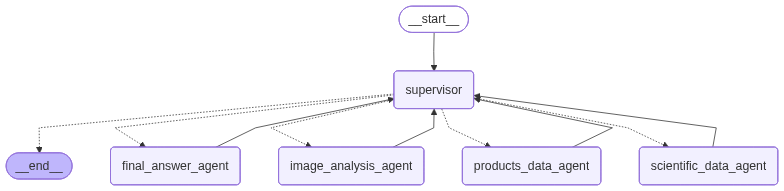

In [323]:
graph

In [324]:
response = graph.invoke(HumanMessage(content="What is my best shampoo for my hair"))

# Debug: Log the response from the workflow
print("[DEBUG] Workflow response:", response)

# Check if the response contains meaningful data
if response.get("messages"):
    for message in response["messages"]:
        print("[DEBUG] Message:", message.content)
else:
    print("[ERROR] No messages returned by the workflow.")

# Check the final answer
final_answer = response.get("final_answer", "No final answer available.")
print("[DEBUG] Final Answer:", final_answer)

🧠 Supervisor Decision: image_analyzer
image_analyzer
{'messages': []}
🧠 Supervisor Decision: scientific_researcher
scientific_researcher
{'messages': [AIMessage(content="📋 Supervisor: Let's start with the image analysis...", additional_kwargs={}, response_metadata={}, id='908664d2-061a-4f0a-8a79-cb4b47d237ff'), AIMessage(content='🖼️ Image Analysis Agent: I\'ve analyzed the image.\n\nHair Type: I\'m unable to identify individuals, but I can describe the hair type.\n\nThe hair in the image appears to be healthy, well-maintained, and shiny. It looks smooth and hydrated with no visible signs of damage, frizz, or split ends. This would likely fall under the category of "Normal & Fine" or "Long hair, fine & normal."', additional_kwargs={}, response_metadata={}, id='035e2d1f-6844-413d-bace-c0b9a637eb47')], 'next_agent': 'supervisor', 'Images_data': 'I\'m unable to identify individuals, but I can describe the hair type.\n\nThe hair in the image appears to be healthy, well-maintained, and shiny

In [325]:
response

{'messages': [AIMessage(content="📋 Supervisor: Let's start with the image analysis...", additional_kwargs={}, response_metadata={}, id='908664d2-061a-4f0a-8a79-cb4b47d237ff'),
  AIMessage(content='🖼️ Image Analysis Agent: I\'ve analyzed the image.\n\nHair Type: I\'m unable to identify individuals, but I can describe the hair type.\n\nThe hair in the image appears to be healthy, well-maintained, and shiny. It looks smooth and hydrated with no visible signs of damage, frizz, or split ends. This would likely fall under the category of "Normal & Fine" or "Long hair, fine & normal."', additional_kwargs={}, response_metadata={}, id='035e2d1f-6844-413d-bace-c0b9a637eb47'),
  AIMessage(content='📋 Supervisor: Image analyzed. Moving to scientific research...', additional_kwargs={}, response_metadata={}, id='51f39e7c-e1b4-441f-aeeb-1f808f9dee1b'),
  AIMessage(content='🔍 Scientific Data Agent: I\'ve retrieved the most relevant data for \'🖼️ Image Analysis Agent: I\'ve analyzed the image.\n\nHair T